# Import packages & functions

In [1]:
import os
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import string
import h5py
from tqdm import tqdm
import webdataset as wds

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from accelerate import Accelerator

# SDXL unCLIP requires code from https://github.com/Stability-AI/generative-models/tree/main
import sgm
from pkgs.MindEyeV2.src.generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder # bigG embedder

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# custom functions #
import pkgs.MindEyeV2.src.utils as utils

import lovely_tensors as lt
lt.monkey_patch()

from csng.data import get_dataloaders
from csng.utils.mix import seed_all
from csng.utils.data import crop

DATA_PATH_BRAINREADER = os.path.join(os.environ["DATA_PATH"], "brainreader")
DATA_PATH_CAT_V1 = os.path.join(os.environ["DATA_PATH"], "cat_V1_spiking_model", "50K_single_trial_dataset")
DATA_PATH_MOUSE_V1 = os.path.join(os.environ["DATA_PATH"], "mouse_v1_sensorium22")
DATA_PATH_MINDEYE = os.path.join(os.environ["DATA_PATH"], "mindeye")
DATA_PATH_MINDEYE_CACHE = os.path.join(DATA_PATH_MINDEYE, "cache")
print(f"{DATA_PATH_BRAINREADER=}\n{DATA_PATH_MINDEYE=}\n{DATA_PATH_MINDEYE_CACHE=}")

!nvidia-smi

/home/sobotka/miniconda3/envs/mindeye/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


DATA_PATH_BRAINREADER='/scratch/izar/sobotka/csng/brainreader'
DATA_PATH_MINDEYE='/scratch/izar/sobotka/csng/mindeye'
DATA_PATH_MINDEYE_CACHE='/scratch/izar/sobotka/csng/mindeye/cache'
Tue Mar 11 14:32:57 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-32GB           On  | 00000000:D8:00.0 Off |                  Off |
| N/A   32C    P0              23W / 250W |      0MiB / 32768Mi

# Configurations

In [2]:
cfg = {
    "device": "cuda",
    "data_type": torch.float32,
    "seed": 0,
    "data": {"mixing_strategy": "parallel_min", "max_training_batches": None},
    "wandb": {"project": os.environ["WANDB_PROJECT"], "group": "mindeye"},
    "data_name": "cat_v1",
    "crop_wins": {
        "mouse_v1": (22, 36),
        "cat_v1": (20, 20),
        "brainreader_mouse": None,
    },
}

### setup data config
# cfg["data"][cfg["data_name"]] = {
#     "device": cfg["device"],
#     "mixing_strategy": cfg["data"]["mixing_strategy"],
#     "max_batches": None,
#     "data_dir": os.path.join(DATA_PATH_BRAINREADER, "data"),
#     "batch_size": 1,
#     # "sessions": (subj_list := list(range(1, 23))),
#     "sessions": (subj_list := [1,2,3,4,5,6,7,8]),
#     "resize_stim_to": (36, 64),
#     "normalize_stim": True,
#     "normalize_resp": True,
#     "div_resp_by_std": True,
#     "clamp_neg_resp": False,
#     "additional_keys": None,
#     "avg_test_resp": True,
#     "drop_last": False,
# }
# cfg["data"]["mouse_v1"] = {
#     "dataset_fn": "sensorium.datasets.static_loaders",
#     "dataset_config": {
#         "paths": [ # from https://gin.g-node.org/cajal/Sensorium2022/src/master
#             os.path.join(DATA_PATH_MOUSE_V1, "static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-1
#             # os.path.join(DATA_PATH_MOUSE_V1, "static22846-10-16-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-2
#             # os.path.join(DATA_PATH_MOUSE_V1, "static23343-5-17-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-3
#             # os.path.join(DATA_PATH_MOUSE_V1, "static23656-14-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-4
#             # os.path.join(DATA_PATH_MOUSE_V1, "static23964-4-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-5
#         ],
#         "normalize": True,
#         "z_score_responses": True,
#         "scale": 0.25, # 256x144 -> 64x36
#         "include_behavior": False,
#         "add_behavior_as_channels": False,
#         "include_eye_position": True,
#         "exclude": None,
#         "file_tree": True,
#         "cuda": False,
#         "batch_size": 8,
#         "drop_last": True,
#         "seed": cfg["seed"],
#         "use_cache": False,
#     },
#     "skip_train": False,
#     "skip_val": False,
#     "skip_test": False,
#     "normalize_neuron_coords": True,
#     "average_test_multitrial": True,
#     "save_test_multitrial": True,
#     "test_batch_size": 7,
#     "device": cfg["device"],
# }
# cfg["data"]["mouse_v1"]["batch_size"] = cfg["data"]["mouse_v1"]["dataset_config"]["batch_size"]
# subj_list = [
#     '-'.join(path.split("/")[-1].replace("static", "").split("-")[:3])
#     for path in cfg["data"]["mouse_v1"]["dataset_config"]["paths"]
# ]
# print(f"{subj_list=}")
cfg["data"]["cat_v1"] = {
    "dataset_config": {
        "train_path": os.path.join(DATA_PATH_CAT_V1, "datasets", "train"),
        "val_path": os.path.join(DATA_PATH_CAT_V1, "datasets", "val"),
        "test_path": os.path.join(DATA_PATH_CAT_V1, "datasets", "test"),
        "image_size": [50, 50],
        "crop": False,
        "batch_size": 8,
        "stim_keys": ("stim",),
        "resp_keys": ("exc_resp", "inh_resp"),
        "return_coords": True,
        "return_ori": False,
        "coords_ori_filepath": os.path.join(DATA_PATH_CAT_V1, "pos_and_ori.pkl"),
        "cached": False,
        "stim_normalize_mean": 46.143,
        "stim_normalize_std": 24.960,
        "resp_normalize_mean": torch.load(
            os.path.join(DATA_PATH_CAT_V1, "responses_mean.pt")
        ),
        "resp_normalize_std": torch.load(
            os.path.join(DATA_PATH_CAT_V1, "responses_std.pt")
        ),
        "clamp_neg_resp": False,
    },
}
cfg["data"]["cat_v1"]["batch_size"] = cfg["data"]["cat_v1"]["dataset_config"]["batch_size"]
subj_list = ["cat_v1"]
print(f"{subj_list=}")


### setup model config
cfg["model"] = {
    "model_name": (model_name := "csng_cat_v1__08-03-25_11-24"),
    "cache_dir": DATA_PATH_MINDEYE_CACHE,
    "outdir": f'{DATA_PATH_MINDEYE}/train_logs/{model_name}',
    "evalsdir": f'{DATA_PATH_MINDEYE}/evals/{model_name}',
    "ckpt_saving": True,
    "ckpt_interval": 1,

    # "subj_list": [6], # list(range(1, 23))
    # "num_voxels_list": [8587],
    # "num_voxels": {
    #     f'subj06': 8587,
    # },

    "subj_list": subj_list,
    # "num_voxels_list": (num_voxels_list := [dset.n_neurons for dset in get_dataloaders(config=cfg)[0]["train"][cfg["data_name"]].datasets]),
    "num_voxels_list": (num_voxels_list := [next(iter(dl))[1].shape[-1] for dl in get_dataloaders(config=cfg)[0]["train"][cfg["data_name"]].dataloaders]),
    "num_voxels": {
        (f"subj{subj:02d}" if subj.isnumeric() else f"subj{subj}"): num_voxels
        for subj, num_voxels in zip(subj_list, num_voxels_list)
    },
    "hidden_dim": 768,
    "n_blocks": 4,
    "clip_scale": 1.,
    "use_prior": True,
    "prior_scale": 30,
    "num_epochs": 100,
    "num_iterations_per_epoch": 500,
    # "mixup_pct": 0.33,
    "mixup_pct": 0.,
    "blurry_recon": True,
    "blur_scale": 0.54,
    "use_image_aug": False,
}

subj_list=['cat_v1']


In [3]:
### create dirs
os.makedirs(cfg["model"]["outdir"], exist_ok=True)
os.makedirs(cfg["model"]["cache_dir"], exist_ok=True)
print(cfg["model"]["outdir"])

/scratch/izar/sobotka/csng/mindeye/train_logs/csng_cat_v1__08-03-25_11-24


# Prep data, models, and dataloaders

In [4]:
seed_all(cfg["seed"])
dls, _ = get_dataloaders(config=cfg)
train_dl, val_dl = dls["train"][cfg["data_name"]], dls["val"][cfg["data_name"]]
train_dls = {subj_name: dl for subj_name, dl in zip(cfg["model"]["num_voxels"].keys(), train_dl.dataloaders)}
display(train_dls)

print("dividing batch size by subj_list, which will then be concatenated across subj during training...") 
cfg["model"]["num_samples_per_epoch"] = sum(len(dl) * dl.batch_size for dl in train_dls.values())
cfg["model"]["num_iterations_per_epoch"] = cfg["model"]["num_samples_per_epoch"] // (cfg["data"][cfg["data_name"]]["batch_size"] * len(cfg["model"]["subj_list"]))

{'subjcat_v1': <torch.utils.data.dataloader.DataLoader at 0x7fce4312b750>}

dividing batch size by subj_list, which will then be concatenated across subj during training...


## Load models

### CLIP image embeddings  model

In [5]:
cfg["model"]["clip_img_embedder_arch"] = "ViT-bigG-14"
cfg["model"]["clip_img_embedder_version"] = "laion2b_s39b_b160k"
cfg["model"]["clip_seq_dim"] = 256
cfg["model"]["clip_emb_dim"] = 1664

clip_img_embedder = FrozenOpenCLIPImageEmbedder(
    arch=cfg["model"]["clip_img_embedder_arch"],
    version=cfg["model"]["clip_img_embedder_version"],
    output_tokens=True,
    only_tokens=True,
    cache_dir=cfg["model"]["cache_dir"],
)
clip_img_embedder.to(cfg["device"])

FrozenOpenCLIPImageEmbedder(
  (model): CLIP(
    (visual): VisionTransformer(
      (conv1): Conv2d(3, 1664, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (patch_dropout): Identity()
      (ln_pre): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): ModuleList(
          (0-47): 48 x ResidualAttentionBlock(
            (ln_1): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=1664, out_features=1664, bias=True)
            )
            (ls_1): Identity()
            (ln_2): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=1664, out_features=8192, bias=True)
              (gelu): GELU(approximate='none')
              (c_proj): Linear(in_features=8192, out_features=1664, bias=True)
            )
            (ls_2): Identity()


### SD VAE

In [6]:
if cfg["model"]["blurry_recon"]:
    ### SD VAE
    from diffusers import AutoencoderKL
    cfg["model"]["autoenc"] = {
        "down_block_types": ['DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D'],
        "up_block_types": ['UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D'],
        "block_out_channels": [128, 256, 512, 512],
        "layers_per_block": 2,
        "sample_size": 256,
    }
    autoenc = AutoencoderKL(**cfg["model"]["autoenc"])
    autoenc.load_state_dict(torch.load(f'{cfg["model"]["cache_dir"]}/sd_image_var_autoenc.pth'))
    autoenc.eval()
    autoenc.requires_grad_(False)
    autoenc.to(cfg["device"])
    utils.count_params(autoenc)

    ### VICRegL ConvNext-XL
    from pkgs.MindEyeV2.src.autoencoder.convnext import ConvnextXL
    cnx = ConvnextXL(f'{cfg["model"]["cache_dir"]}/convnext_xlarge_alpha0.75_fullckpt.pth')
    cnx.requires_grad_(False)
    cnx.eval()
    cnx.to(cfg["device"])
    utils.count_params(cnx)

    import kornia
    from kornia.augmentation.container import AugmentationSequential
    mean = torch.tensor([0.485, 0.456, 0.406]).to(cfg["device"]).reshape(1,3,1,1)
    std = torch.tensor([0.228, 0.224, 0.225]).to(cfg["device"]).reshape(1,3,1,1)
    blur_augs = AugmentationSequential(
        kornia.augmentation.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1, p=0.8),
        kornia.augmentation.RandomGrayscale(p=0.1),
        kornia.augmentation.RandomSolarize(p=0.1),
        kornia.augmentation.RandomResizedCrop((224,224), scale=(.9,.9), ratio=(1,1), p=1.0),
        data_keys=["input"],
    )

param counts:
83,653,863 total
0 trainable
param counts:
349,687,808 total
0 trainable


### MindEye modules

In [7]:
class MindEyeModule(nn.Module):
    def __init__(self):
        super(MindEyeModule, self).__init__()
    
    def forward(self, x):
        return x

class RidgeRegression(torch.nn.Module):
    # make sure to add weight_decay when initializing optimizer to enable regularization
    def __init__(self, input_sizes, out_features): 
        super(RidgeRegression, self).__init__()
        self.out_features = out_features
        self.linears = torch.nn.ModuleList([
            torch.nn.Linear(input_size, out_features) for input_size in input_sizes
        ])
    
    def forward(self, x, subj_idx):
        out = self.linears[subj_idx](x[:,0]).unsqueeze(1)
        return out

In [8]:
### init model
model = MindEyeModule()
model.ridge = RidgeRegression(cfg["model"]["num_voxels_list"], out_features=cfg["model"]["hidden_dim"])
utils.count_params(model.ridge)
utils.count_params(model)

# test on subject 1 with fake data
b = torch.randn((2,1,cfg["model"]["num_voxels_list"][0]))
print(b.shape, model.ridge(b,0).shape)

param counts:
36,000,768 total
36,000,768 trainable
param counts:
36,000,768 total
36,000,768 trainable
torch.Size([2, 1, 46875]) torch.Size([2, 1, 768])


In [9]:
from pkgs.MindEyeV2.src.models import BrainNetwork

### backbone
cfg["model"]["brainnetwork"] = {
    "h": cfg["model"]["hidden_dim"],
    "in_dim": cfg["model"]["hidden_dim"],
    "seq_len": 1,
    "n_blocks": cfg["model"]["n_blocks"],
    "clip_size": cfg["model"]["clip_emb_dim"],
    "out_dim": cfg["model"]["clip_emb_dim"] * cfg["model"]["clip_seq_dim"],
    "blurry_recon": cfg["model"]["blurry_recon"],
    "clip_scale": cfg["model"]["clip_scale"],
}
model.backbone = BrainNetwork(**cfg["model"]["brainnetwork"])
utils.count_params(model.backbone)
utils.count_params(model)

# test that the model works on some fake data
b = torch.randn((2,1,cfg["model"]["hidden_dim"]))
print("b.shape",b.shape)

backbone_, clip_, blur_ = model.backbone(b)
print(backbone_.shape, clip_.shape, blur_[0].shape, blur_[1].shape)

param counts:
345,356,284 total
345,356,284 trainable
param counts:
381,357,052 total
381,357,052 trainable
b.shape torch.Size([2, 1, 768])
torch.Size([2, 256, 1664]) torch.Size([2, 256, 1664]) torch.Size([2, 4, 28, 28]) torch.Size([2, 49, 512])


### Adding diffusion prior + unCLIP if use_prior=True

In [10]:
if cfg["model"]["use_prior"]:
    from pkgs.MindEyeV2.src.models import *

    ### setup diffusion prior network
    cfg["model"]["out_dim"] = cfg["model"]["clip_emb_dim"]
    cfg["model"]["depth"] = 5
    cfg["model"]["dim_head"] = 52
    cfg["model"]["heads"] = cfg["model"]["clip_emb_dim"] // cfg["model"]["dim_head"]
    cfg["model"]["timesteps"] = 100
    cfg["model"]["prior_network"] = {
        "dim": cfg["model"]["out_dim"],
        "depth": cfg["model"]["depth"],
        "dim_head": cfg["model"]["dim_head"],
        "heads": cfg["model"]["heads"],
        "causal": False,
        "num_tokens": cfg["model"]["clip_seq_dim"],
        "learned_query_mode": "pos_emb",
        "normformer": True,
    }
    cfg["model"]["brain_diffusion_prior"] = {
        "image_embed_dim": cfg["model"]["out_dim"],
        "condition_on_text_encodings": False,
        "timesteps": cfg["model"]["timesteps"],
        "cond_drop_prob": 0.2,
        "image_embed_scale": None,
    }

    prior_network = PriorNetwork(**cfg["model"]["prior_network"])
    model.diffusion_prior = BrainDiffusionPrior(net=prior_network, **cfg["model"]["brain_diffusion_prior"])
    utils.count_params(model.diffusion_prior)
    utils.count_params(model)

param counts:
220,955,800 total
220,955,784 trainable
param counts:
602,312,852 total
602,312,836 trainable


### Setup optimizer / lr / ckpt saving

In [11]:
cfg["model"]["optimization"] = {
    "no_decay": ['bias', 'LayerNorm.bias', 'LayerNorm.weight'],
    "max_lr": 3e-4,
    "lr_scheduler_type": 'cycle',
}

opt_grouped_parameters = [
    {'params': [p for n, p in model.ridge.named_parameters()], 'weight_decay': 1e-2},
    {'params': [p for n, p in model.backbone.named_parameters() if not any(nd in n for nd in cfg["model"]["optimization"]["no_decay"])], 'weight_decay': 1e-2},
    {'params': [p for n, p in model.backbone.named_parameters() if any(nd in n for nd in cfg["model"]["optimization"]["no_decay"])], 'weight_decay': 0.0},
]
if cfg["model"]["use_prior"]:
    opt_grouped_parameters.extend([
        {'params': [p for n, p in model.diffusion_prior.named_parameters() if not any(nd in n for nd in cfg["model"]["optimization"]["no_decay"])], 'weight_decay': 1e-2},
        {'params': [p for n, p in model.diffusion_prior.named_parameters() if any(nd in n for nd in cfg["model"]["optimization"]["no_decay"])], 'weight_decay': 0.0}
    ])

optimizer = torch.optim.AdamW(opt_grouped_parameters, lr=cfg["model"]["optimization"]["max_lr"])

if cfg["model"]["optimization"]["lr_scheduler_type"] == 'linear':
    lr_scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer,
        total_iters=cfg["model"]["num_epochs"]*cfg["model"]["num_iterations_per_epoch"],
        last_epoch=-1
    )
elif cfg["model"]["optimization"]["lr_scheduler_type"] == 'cycle':
    cfg["model"]["optimization"]["total_steps"] = int(np.floor(cfg["model"]["num_epochs"]*cfg["model"]["num_iterations_per_epoch"]))
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=cfg["model"]["optimization"]["max_lr"],
        total_steps=cfg["model"]["optimization"]["total_steps"],
        final_div_factor=1000,
        last_epoch=-1, pct_start=2/cfg["model"]["num_epochs"],
    )
    print("total_steps", cfg["model"]["optimization"]["total_steps"])

def save_ckpt(tag):
    ckpt_path = cfg["model"]["outdir"]+f'/{tag}.pth'
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
        'train_losses': losses,
        'test_losses': test_losses,
        'lrs': lrs,
        "cfg": cfg,
        "best": best,
    }, ckpt_path)
    print(f"\n---saved {cfg['model']['outdir']}/{tag} ckpt!---\n")

def load_ckpt(tag):
    ckpt_path = cfg["model"]["outdir"]+f'/{tag}.pth'
    checkpoint = torch.load(ckpt_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    epoch = checkpoint['epoch']
    losses = checkpoint['train_losses']
    test_losses = checkpoint['test_losses']
    lrs = checkpoint['lrs']
    best = checkpoint['best']
    optimizer.zero_grad()
    print(f"\n---loaded {cfg['model']['outdir']}/{tag} ckpt!---\n")
    return epoch, losses, test_losses, lrs, checkpoint["cfg"], best

print("\nDone with model preparations!")
num_params = utils.count_params(model)

total_steps 562500

Done with model preparations!
param counts:
602,312,852 total
602,312,836 trainable


In [12]:
model

MindEyeModule(
  (ridge): RidgeRegression(
    (linears): ModuleList(
      (0): Linear(in_features=46875, out_features=768, bias=True)
    )
  )
  (backbone): BrainNetwork(
    (mixer_blocks1): ModuleList(
      (0-3): 4 x Sequential(
        (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (1): Sequential(
          (0): Linear(in_features=768, out_features=768, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.15, inplace=False)
          (3): Linear(in_features=768, out_features=768, bias=True)
        )
      )
    )
    (mixer_blocks2): ModuleList(
      (0-3): 4 x Sequential(
        (0): LayerNorm((1,), eps=1e-05, elementwise_affine=True)
        (1): Sequential(
          (0): Linear(in_features=1, out_features=1, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.15, inplace=False)
          (3): Linear(in_features=1, out_features=1, bias=True)
        )
      )
    )
    (backbone_linear): Linear(in_fea

In [13]:
epoch, losses, test_losses, lrs, cfg, best = load_ckpt("last")


---loaded /scratch/izar/sobotka/csng/mindeye/train_logs/csng_cat_v1__08-03-25_11-24/last ckpt!---



In [14]:
model.to(cfg["device"])
optimizer.zero_grad()
epoch, losses, test_losses, lrs, cfg, best = load_ckpt("last")


---loaded /scratch/izar/sobotka/csng/mindeye/train_logs/csng_cat_v1__08-03-25_11-24/last ckpt!---



# Weights and Biases

In [15]:
if cfg.get("wandb", None) is not None: # only use main process for wandb logging
    import wandb
    wandb_log = wandb.init(
        id=cfg["model"]["model_name"],
        name=cfg["model"]["model_name"],
        config=cfg,
        resume="allow",
        **cfg["wandb"],
    )
else:
    wandb_log = False

wandb: Currently logged in as: johnny1188 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


# Main

In [16]:
### img transform (1x36x64 -> 3x224x224)
img_tform = transforms.Compose([
    transforms.Lambda(lambda x: crop(x, cfg["crop_wins"][cfg["data_name"]])),
    transforms.Resize((224, 224), antialias=True),
    transforms.Lambda(lambda x: x.repeat(1, 3, 1, 1)),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
if cfg["model"]["use_image_aug"]:
    img_augment = AugmentationSequential(
        kornia.augmentation.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1, p=0.3),
        same_on_batch=False,
        data_keys=["input"],
    )

  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

[E23/100 I0/5625]


/home/sobotka/miniconda3/envs/mindeye/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  Loss 7.01754093170166
[E23/100 I50/5625]
  Loss 7.017935752868652
[E23/100 I100/5625]
  Loss 13.053179740905762
[E23/100 I150/5625]
  Loss 8.102657318115234
[E23/100 I200/5625]
  Loss 9.30400276184082
[E23/100 I250/5625]
  Loss 6.834588050842285
[E23/100 I300/5625]
  Loss 6.806634902954102
[E23/100 I350/5625]
  Loss 7.20797061920166
[E23/100 I400/5625]
  Loss 6.410481929779053
[E23/100 I450/5625]
  Loss 8.23912239074707
[E23/100 I500/5625]
  Loss 5.493373870849609
[E23/100 I550/5625]
  Loss 7.688549041748047
[E23/100 I600/5625]
  Loss 7.767282962799072
[E23/100 I650/5625]
  Loss 10.18304443359375
[E23/100 I700/5625]
  Loss 8.021316528320312
[E23/100 I750/5625]
  Loss 8.418025016784668
[E23/100 I800/5625]
  Loss 7.820982456207275
[E23/100 I850/5625]
  Loss 10.23747444152832
[E23/100 I900/5625]
  Loss 7.099230766296387
[E23/100 I950/5625]
  Loss 12.475447654724121
[E23/100 I1000/5625]
  Loss 6.26273250579834
[E23/100 I1050/5625]
  Loss 11.436453819274902
[E23/100 I1100/5625]
  Loss 6.4

  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  | 0/77 [2:33:08<?, ?it/s, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7fcc7012de90>, test/blurry_pixcorr=0.807, test/loss=8.83, test/loss_clip_total=0.00256, test/loss_prior=0.294, test/num_steps=27, test/test_bwd_pct_correct=0.999, test/test_fwd_pct_correct=1, train/blurry_pixcorr=0.891, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.34, train/los


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_cat_v1__08-03-25_11-24/last ckpt!---

Finished epoch 23 / 100


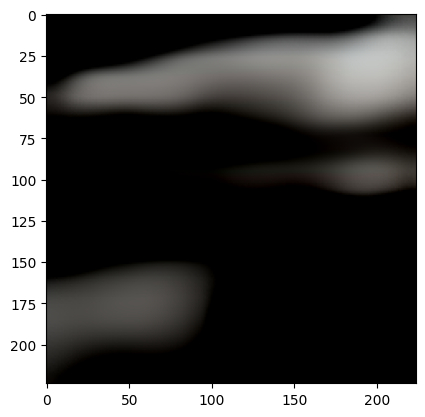

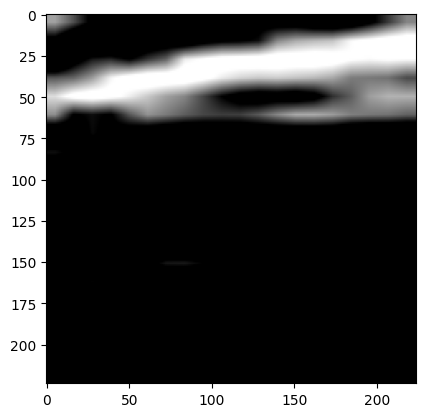

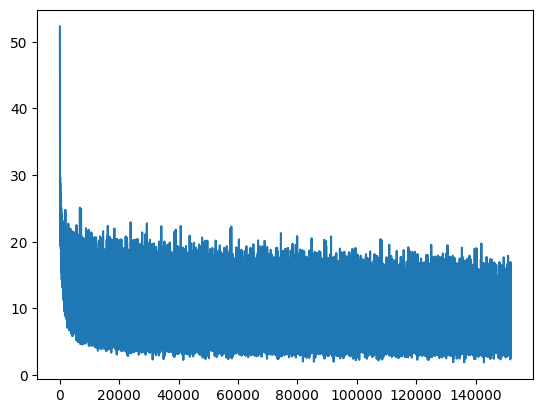

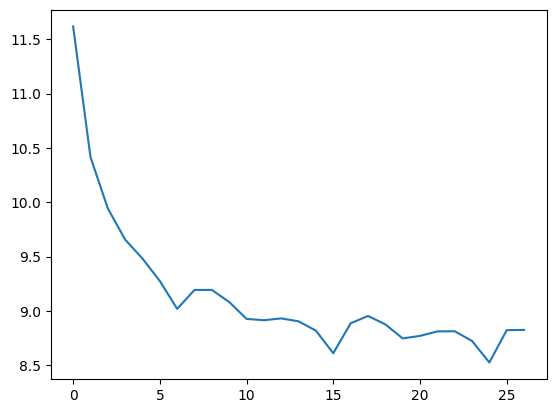

  1%|███████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            | 1/77 [2:33:16<194:09:17, 9196.81s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7fcc7012de90>, test/blurry_pixcorr=0.807, test/loss=8.83, test/loss_clip_total=0.00256, test/loss_prior=0.294, test/num_steps=27, test/test_bwd_pct_correct=0.999, test/test_fwd_pct_correct=1, train/blurry_pixcorr=0.891, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.34, train/los

[E24/100 I0/5625]
  Loss 10.052967071533203
[E24/100 I50/5625]
  Loss 11.448596000671387
[E24/100 I100/5625]
  Loss 8.919721603393555
[E24/100 I150/5625]
  Loss 15.110262870788574
[E24/100 I200/5625]
  Loss 6.05350399017334
[E24/100 I250/5625]
  Loss 9.367624282836914
[E24/100 I300/5625]
  Loss 6.203744888305664
[E24/100 I350/5625]
  Loss 8.277360916137695
[E24/100 I400/5625]
  Loss 7.320354461669922
[E24/100 I450/5625]
  Loss 12.286148071289062
[E24/100 I500/5625]
  Loss 6.607153415679932
[E24/100 I550/5625]
  Loss 5.110329627990723
[E24/100 I600/5625]
  Loss 4.740170001983643
[E24/100 I650/5625]
  Loss 8.089518547058105
[E24/100 I700/5625]
  Loss 6.352702617645264
[E24/100 I750/5625]
  Loss 8.588006973266602
[E24/100 I800/5625]
  Loss 6.951189994812012
[E24/100 I850/5625]
  Loss 4.627488136291504
[E24/100 I900/5625]
  Loss 8.399750709533691
[E24/100 I950/5625]
  Loss 6.9131669998168945
[E24/100 I1000/5625]
  Loss 7.0664801597595215
[E24/100 I1050/5625]
  Loss 9.204944610595703
[E24/1

  1%|███████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 1/77 [5:03:27<194:09:17, 9196.81s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7fcb5238d490>, test/blurry_pixcorr=0.805, test/loss=8.72, test/loss_clip_total=0.00271, test/loss_prior=0.29, test/num_steps=28, test/test_bwd_pct_correct=0.999, test/test_fwd_pct_correct=1, train/blurry_pixcorr=0.896, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.33, train/lo


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_cat_v1__08-03-25_11-24/ep24 ckpt!---




---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_cat_v1__08-03-25_11-24/last ckpt!---

Finished epoch 24 / 100


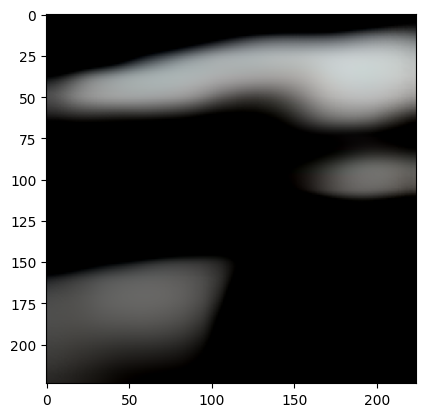

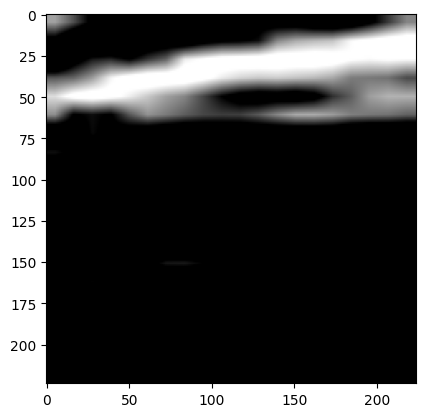

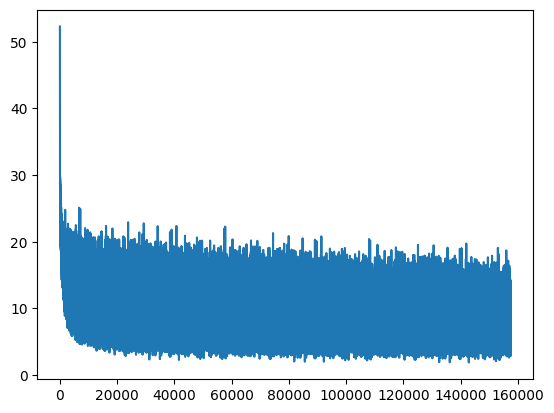

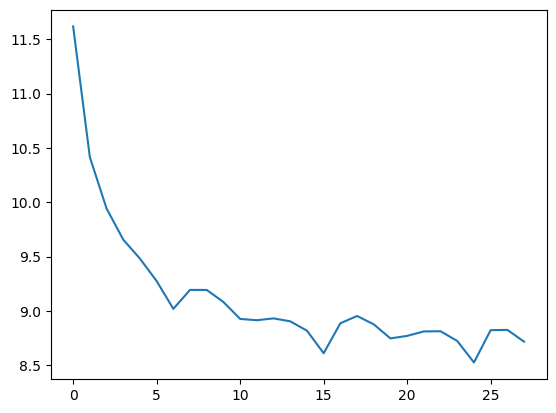

  3%|███████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 2/77 [5:03:40<189:28:57, 9095.17s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7fcb5238d490>, test/blurry_pixcorr=0.805, test/loss=8.72, test/loss_clip_total=0.00271, test/loss_prior=0.29, test/num_steps=28, test/test_bwd_pct_correct=0.999, test/test_fwd_pct_correct=1, train/blurry_pixcorr=0.896, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.33, train/lo

[E25/100 I0/5625]
  Loss 5.592360973358154
[E25/100 I50/5625]
  Loss 7.591372489929199
[E25/100 I100/5625]
  Loss 10.012262344360352
[E25/100 I150/5625]
  Loss 11.497116088867188
[E25/100 I200/5625]
  Loss 5.408064842224121
[E25/100 I250/5625]
  Loss 9.852317810058594
[E25/100 I300/5625]
  Loss 6.442495346069336
[E25/100 I350/5625]
  Loss 10.171109199523926
[E25/100 I400/5625]
  Loss 6.382715225219727
[E25/100 I450/5625]
  Loss 7.006050109863281
[E25/100 I500/5625]
  Loss 7.225411415100098
[E25/100 I550/5625]
  Loss 5.520646572113037
[E25/100 I600/5625]
  Loss 8.912971496582031
[E25/100 I650/5625]
  Loss 6.81573486328125
[E25/100 I700/5625]
  Loss 7.355994701385498
[E25/100 I750/5625]
  Loss 7.412021160125732
[E25/100 I800/5625]
  Loss 4.302737236022949
[E25/100 I850/5625]
  Loss 8.71881103515625
[E25/100 I900/5625]
  Loss 9.735403060913086
[E25/100 I950/5625]
  Loss 5.465193748474121
[E25/100 I1000/5625]
  Loss 8.366239547729492
[E25/100 I1050/5625]
  Loss 5.462502956390381
[E25/100 I

  3%|███████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  | 2/77 [7:34:53<189:28:57, 9095.17s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7fcc70130950>, test/blurry_pixcorr=0.804, test/loss=8.74, test/loss_clip_total=0.00462, test/loss_prior=0.291, test/num_steps=29, test/test_bwd_pct_correct=0.999, test/test_fwd_pct_correct=1, train/blurry_pixcorr=0.895, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.22, train/loss_


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_cat_v1__08-03-25_11-24/last ckpt!---

Finished epoch 25 / 100


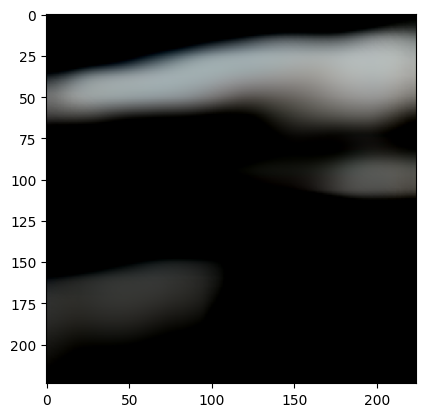

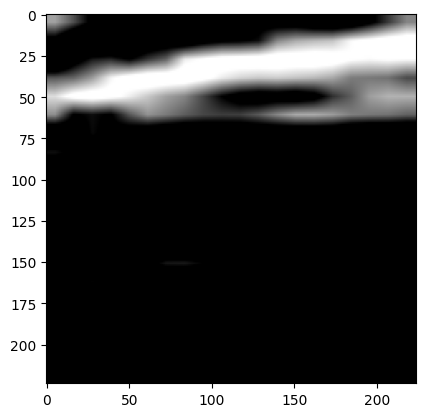

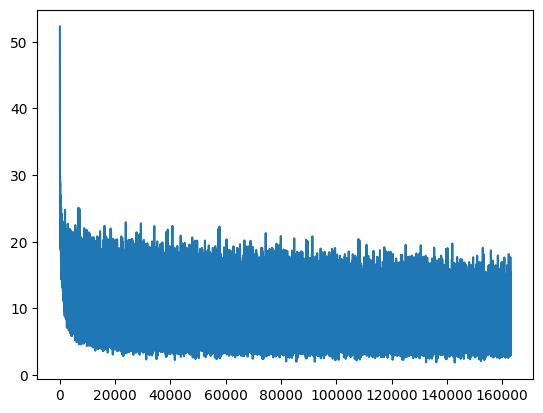

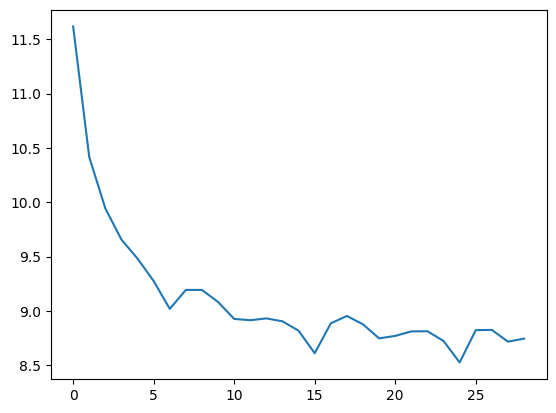

  4%|███████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 3/77 [7:35:00<186:48:32, 9088.00s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7fcc70130950>, test/blurry_pixcorr=0.804, test/loss=8.74, test/loss_clip_total=0.00462, test/loss_prior=0.291, test/num_steps=29, test/test_bwd_pct_correct=0.999, test/test_fwd_pct_correct=1, train/blurry_pixcorr=0.895, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.22, train/loss_

[E26/100 I0/5625]
  Loss 9.38137435913086
[E26/100 I50/5625]
  Loss 9.213518142700195
[E26/100 I100/5625]
  Loss 6.099549293518066
[E26/100 I150/5625]
  Loss 6.051478862762451
[E26/100 I200/5625]
  Loss 9.906282424926758
[E26/100 I250/5625]
  Loss 10.028900146484375
[E26/100 I300/5625]
  Loss 8.199040412902832
[E26/100 I350/5625]
  Loss 10.463560104370117
[E26/100 I400/5625]
  Loss 10.304906845092773
[E26/100 I450/5625]
  Loss 6.136212348937988
[E26/100 I500/5625]
  Loss 11.666264533996582
[E26/100 I550/5625]
  Loss 4.325973033905029
[E26/100 I600/5625]
  Loss 6.97641134262085
[E26/100 I650/5625]
  Loss 9.592300415039062
[E26/100 I700/5625]
  Loss 9.036466598510742
[E26/100 I750/5625]
  Loss 8.17883586883545
[E26/100 I800/5625]
  Loss 9.376880645751953
[E26/100 I850/5625]
  Loss 6.555663585662842
[E26/100 I900/5625]
  Loss 7.058867454528809
[E26/100 I950/5625]
  Loss 8.624734878540039
[E26/100 I1000/5625]
  Loss 10.6348295211792
[E26/100 I1050/5625]
  Loss 10.979523658752441
[E26/100 I

  4%|███████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 3/77 [10:05:04<186:48:32, 9088.00s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7fcc70090510>, test/blurry_pixcorr=0.808, test/loss=8.79, test/loss_clip_total=0.00216, test/loss_prior=0.293, test/num_steps=30, test/test_bwd_pct_correct=1, test/test_fwd_pct_correct=1, train/blurry_pixcorr=nan, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.19, train/loss_


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_cat_v1__08-03-25_11-24/last ckpt!---

Finished epoch 26 / 100


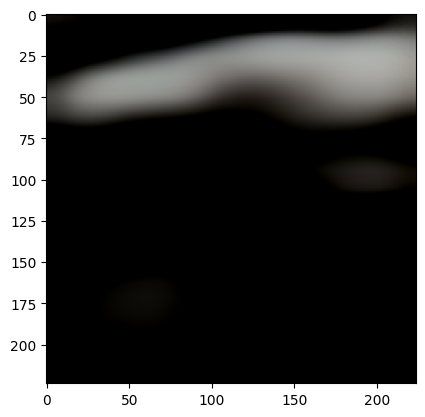

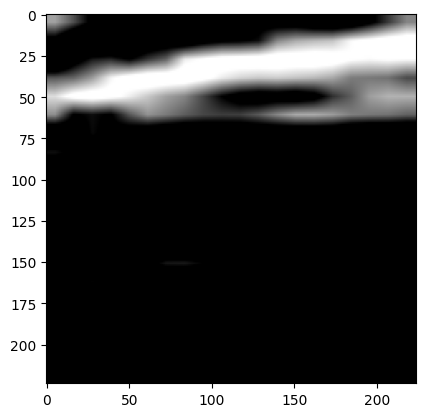

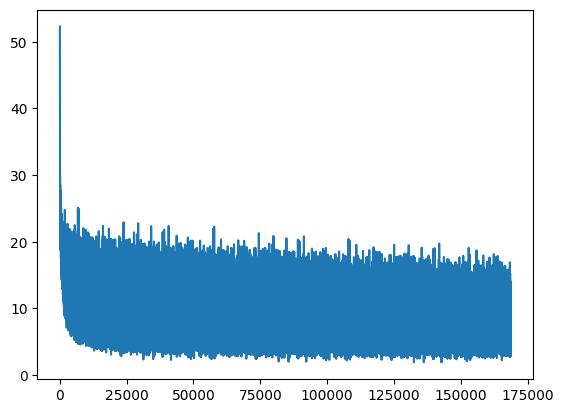

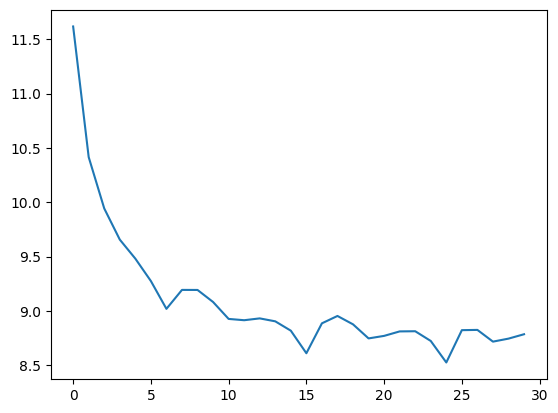

  5%|███████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | 4/77 [10:05:13<183:40:57, 9058.32s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7fcc70090510>, test/blurry_pixcorr=0.808, test/loss=8.79, test/loss_clip_total=0.00216, test/loss_prior=0.293, test/num_steps=30, test/test_bwd_pct_correct=1, test/test_fwd_pct_correct=1, train/blurry_pixcorr=nan, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.19, train/loss_

[E27/100 I0/5625]
  Loss 14.122517585754395
[E27/100 I50/5625]
  Loss 7.015736103057861
[E27/100 I100/5625]
  Loss 7.36243200302124
[E27/100 I150/5625]
  Loss 7.609619140625
[E27/100 I200/5625]
  Loss 8.111254692077637
[E27/100 I250/5625]
  Loss 8.943802833557129
[E27/100 I300/5625]
  Loss 7.071263313293457
[E27/100 I350/5625]
  Loss 10.417450904846191
[E27/100 I400/5625]
  Loss 10.882278442382812
[E27/100 I450/5625]
  Loss 9.358207702636719
[E27/100 I500/5625]
  Loss 6.984620094299316
[E27/100 I550/5625]
  Loss 5.754659652709961
[E27/100 I600/5625]
  Loss 8.330634117126465
[E27/100 I650/5625]
  Loss 6.768334865570068
[E27/100 I700/5625]
  Loss 10.093940734863281
[E27/100 I750/5625]
  Loss 11.2997465133667
[E27/100 I800/5625]
  Loss 7.761673450469971
[E27/100 I850/5625]
  Loss 6.7136101722717285
[E27/100 I900/5625]
  Loss 13.347084999084473
[E27/100 I950/5625]
  Loss 10.84816837310791
[E27/100 I1000/5625]
  Loss 5.565151691436768
[E27/100 I1050/5625]
  Loss 4.0274505615234375
[E27/100 

  5%|███████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | 4/77 [12:37:15<183:40:57, 9058.32s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7fcc700cf5d0>, test/blurry_pixcorr=0.806, test/loss=8.78, test/loss_clip_total=0.00305, test/loss_prior=0.293, test/num_steps=31, test/test_bwd_pct_correct=1, test/test_fwd_pct_correct=1, train/blurry_pixcorr=0.9, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.11, train/loss


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_cat_v1__08-03-25_11-24/last ckpt!---

Finished epoch 27 / 100


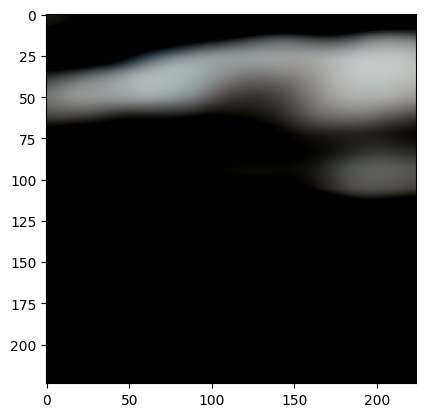

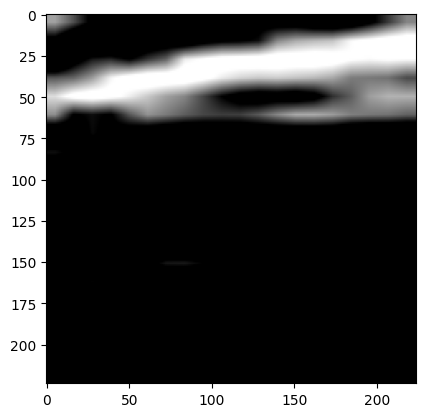

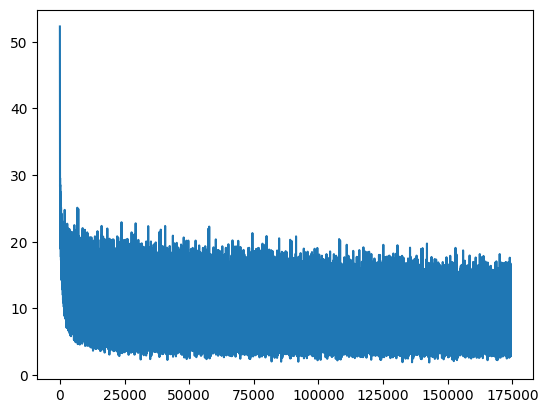

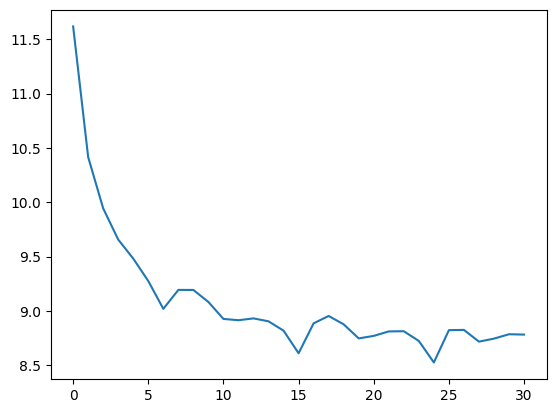

  6%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 5/77 [12:37:23<181:41:11, 9084.32s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7fcc700cf5d0>, test/blurry_pixcorr=0.806, test/loss=8.78, test/loss_clip_total=0.00305, test/loss_prior=0.293, test/num_steps=31, test/test_bwd_pct_correct=1, test/test_fwd_pct_correct=1, train/blurry_pixcorr=0.9, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.11, train/loss

[E28/100 I0/5625]
  Loss 9.001550674438477
[E28/100 I50/5625]
  Loss 9.615323066711426
[E28/100 I100/5625]
  Loss 8.3141450881958
[E28/100 I150/5625]
  Loss 8.19356632232666
[E28/100 I200/5625]
  Loss 6.100703716278076
[E28/100 I250/5625]
  Loss 10.036905288696289
[E28/100 I300/5625]
  Loss 8.855907440185547
[E28/100 I350/5625]
  Loss 7.6938347816467285
[E28/100 I400/5625]
  Loss 6.030831813812256
[E28/100 I450/5625]
  Loss 6.0654144287109375
[E28/100 I500/5625]
  Loss 11.352911949157715
[E28/100 I550/5625]
  Loss 9.772929191589355
[E28/100 I600/5625]
  Loss 7.896111488342285
[E28/100 I650/5625]
  Loss 9.24329662322998
[E28/100 I700/5625]
  Loss 9.62784481048584
[E28/100 I750/5625]
  Loss 4.836522579193115
[E28/100 I800/5625]
  Loss 4.608643531799316
[E28/100 I850/5625]
  Loss 12.295454978942871
[E28/100 I900/5625]
  Loss 11.92557144165039
[E28/100 I950/5625]
  Loss 8.067573547363281
[E28/100 I1000/5625]
  Loss 9.13135814666748
[E28/100 I1050/5625]
  Loss 7.465087890625
[E28/100 I1100/

  6%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 5/77 [15:12:35<181:41:11, 9084.32s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7fcb4e715f90>, test/blurry_pixcorr=0.809, test/loss=8.73, test/loss_clip_total=0.0024, test/loss_prior=0.291, test/num_steps=32, test/test_bwd_pct_correct=1, test/test_fwd_pct_correct=1, train/blurry_pixcorr=nan, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.04, train/loss_


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_cat_v1__08-03-25_11-24/last ckpt!---

Finished epoch 28 / 100


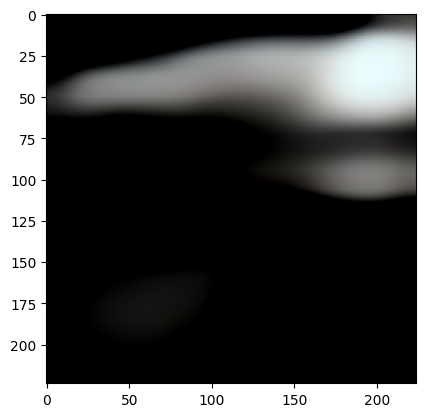

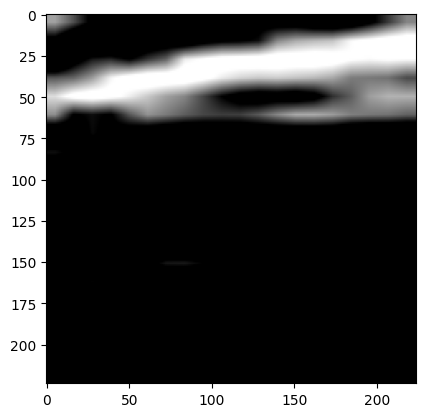

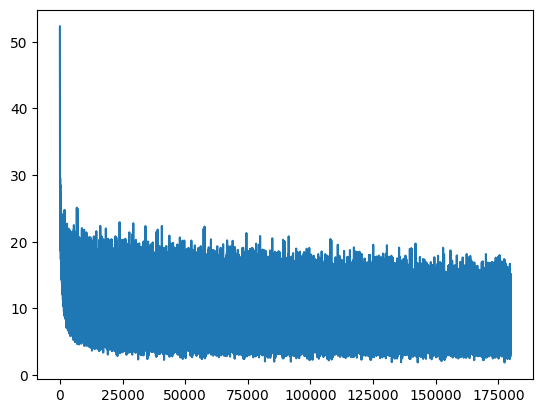

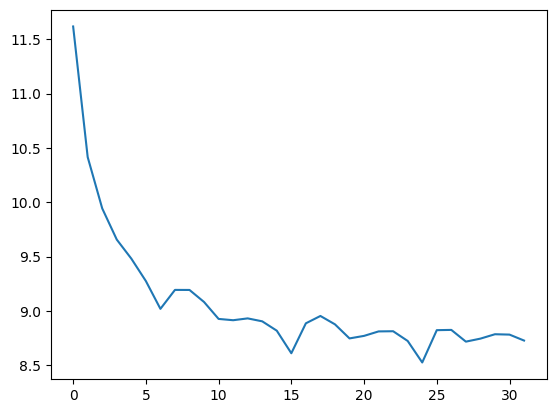

  8%|██████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | 6/77 [15:12:43<180:44:24, 9164.29s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7fcb4e715f90>, test/blurry_pixcorr=0.809, test/loss=8.73, test/loss_clip_total=0.0024, test/loss_prior=0.291, test/num_steps=32, test/test_bwd_pct_correct=1, test/test_fwd_pct_correct=1, train/blurry_pixcorr=nan, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.04, train/loss_

[E29/100 I0/5625]
  Loss 4.1699910163879395
[E29/100 I50/5625]
  Loss 11.950061798095703
[E29/100 I100/5625]
  Loss 7.133464813232422
[E29/100 I150/5625]
  Loss 10.182847023010254
[E29/100 I200/5625]
  Loss 8.477054595947266
[E29/100 I250/5625]
  Loss 3.824871063232422
[E29/100 I300/5625]
  Loss 9.449533462524414
[E29/100 I350/5625]
  Loss 8.766430854797363
[E29/100 I400/5625]
  Loss 8.926079750061035
[E29/100 I450/5625]
  Loss 6.866291522979736
[E29/100 I500/5625]
  Loss 11.016931533813477
[E29/100 I550/5625]
  Loss 6.775347709655762
[E29/100 I600/5625]
  Loss 7.747724533081055
[E29/100 I650/5625]
  Loss 6.413479804992676
[E29/100 I700/5625]
  Loss 4.477049827575684
[E29/100 I750/5625]
  Loss 5.6811089515686035
[E29/100 I800/5625]
  Loss 9.50015640258789
[E29/100 I850/5625]
  Loss 8.142242431640625
[E29/100 I900/5625]
  Loss 9.369688034057617
[E29/100 I950/5625]
  Loss 8.531679153442383
[E29/100 I1000/5625]
  Loss 7.652768611907959
[E29/100 I1050/5625]
  Loss 10.826471328735352
[E29/1

  8%|██████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 6/77 [17:46:38<180:44:24, 9164.29s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7fcb52309590>, test/blurry_pixcorr=0.81, test/loss=8.49, test/loss_clip_total=0.00235, test/loss_prior=0.283, test/num_steps=33, test/test_bwd_pct_correct=0.999, test/test_fwd_pct_correct=1, train/blurry_pixcorr=0.901, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.05, train/loss_


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_cat_v1__08-03-25_11-24/ep29 ckpt!---




---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_cat_v1__08-03-25_11-24/last ckpt!---

Finished epoch 29 / 100


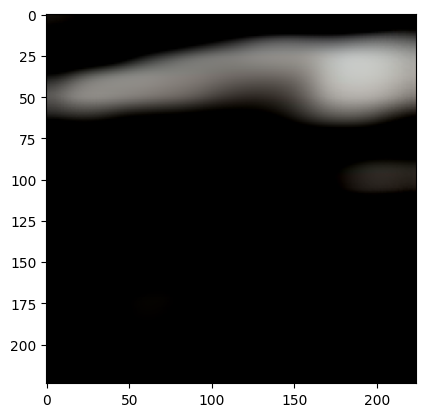

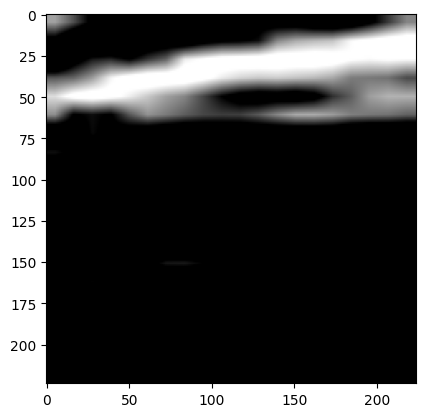

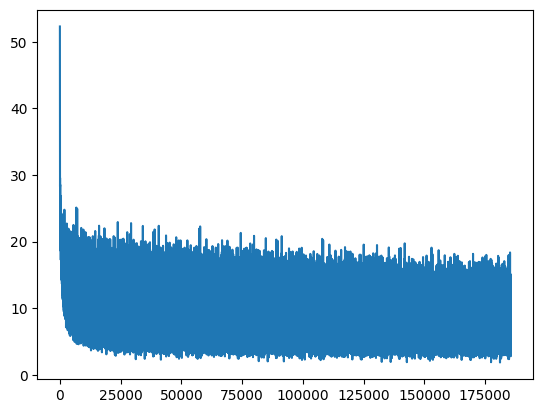

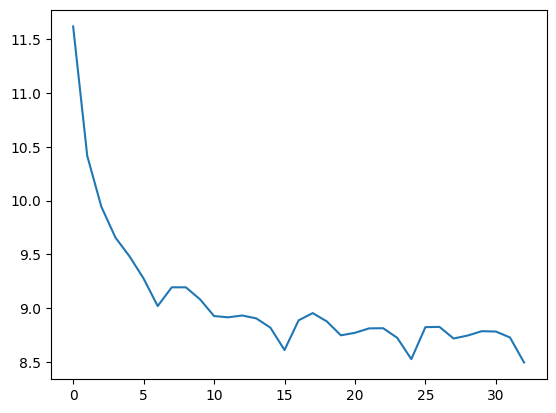

  9%|██████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            | 7/77 [17:46:52<178:44:02, 9192.03s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7fcb52309590>, test/blurry_pixcorr=0.81, test/loss=8.49, test/loss_clip_total=0.00235, test/loss_prior=0.283, test/num_steps=33, test/test_bwd_pct_correct=0.999, test/test_fwd_pct_correct=1, train/blurry_pixcorr=0.901, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.05, train/loss_

[E30/100 I0/5625]
  Loss 4.173691272735596
[E30/100 I50/5625]
  Loss 6.439080715179443
[E30/100 I100/5625]
  Loss 3.5024094581604004
[E30/100 I150/5625]
  Loss 9.243226051330566
[E30/100 I200/5625]
  Loss 7.944872856140137
[E30/100 I250/5625]
  Loss 10.088308334350586
[E30/100 I300/5625]
  Loss 8.162003517150879
[E30/100 I350/5625]
  Loss 7.2522969245910645
[E30/100 I400/5625]
  Loss 7.259772300720215
[E30/100 I450/5625]
  Loss 6.2550950050354
[E30/100 I500/5625]
  Loss 10.495609283447266
[E30/100 I550/5625]
  Loss 3.8763585090637207
[E30/100 I600/5625]
  Loss 8.48180103302002
[E30/100 I650/5625]
  Loss 11.069657325744629
[E30/100 I700/5625]
  Loss 8.100101470947266
[E30/100 I750/5625]
  Loss 9.73557186126709
[E30/100 I800/5625]
  Loss 7.481436729431152
[E30/100 I850/5625]
  Loss 7.003341197967529
[E30/100 I900/5625]
  Loss 9.429919242858887
[E30/100 I950/5625]
  Loss 9.30024242401123
[E30/100 I1000/5625]
  Loss 7.133452415466309
[E30/100 I1050/5625]
  Loss 10.116449356079102
[E30/100 

  9%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 7/77 [20:20:34<178:44:02, 9192.03s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7fcc70080bd0>, test/blurry_pixcorr=0.811, test/loss=8.81, test/loss_clip_total=0.0021, test/loss_prior=0.294, test/num_steps=34, test/test_bwd_pct_correct=1, test/test_fwd_pct_correct=1, train/blurry_pixcorr=0.905, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.01, train/los


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_cat_v1__08-03-25_11-24/last ckpt!---

Finished epoch 30 / 100


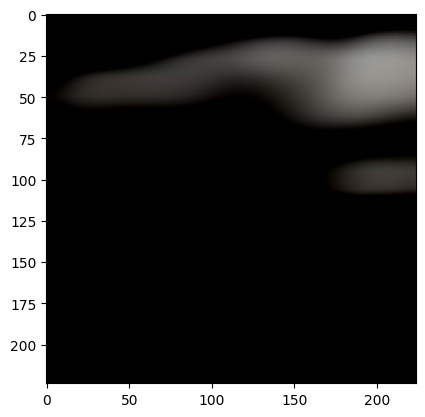

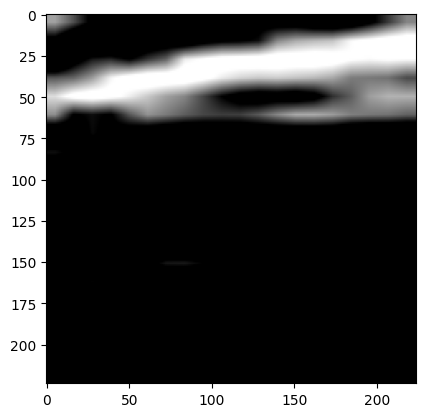

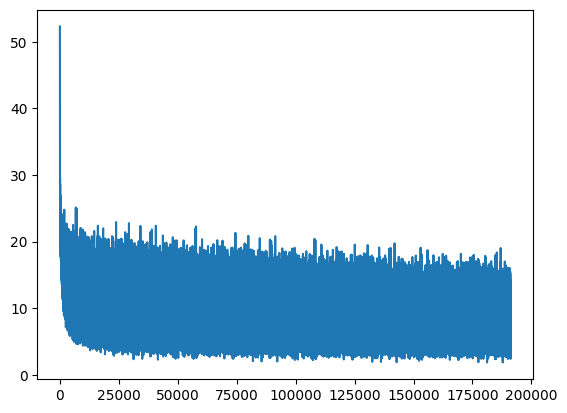

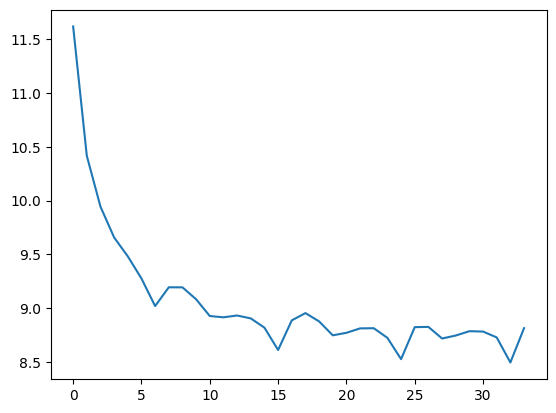

 10%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | 8/77 [20:20:41<176:24:27, 9203.87s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7fcc70080bd0>, test/blurry_pixcorr=0.811, test/loss=8.81, test/loss_clip_total=0.0021, test/loss_prior=0.294, test/num_steps=34, test/test_bwd_pct_correct=1, test/test_fwd_pct_correct=1, train/blurry_pixcorr=0.905, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.01, train/los

[E31/100 I0/5625]
  Loss 14.021044731140137
[E31/100 I50/5625]
  Loss 6.380986213684082
[E31/100 I100/5625]
  Loss 10.811808586120605
[E31/100 I150/5625]
  Loss 9.244571685791016
[E31/100 I200/5625]
  Loss 8.024161338806152
[E31/100 I250/5625]
  Loss 7.780704498291016
[E31/100 I300/5625]
  Loss 6.482994556427002
[E31/100 I350/5625]
  Loss 8.913803100585938
[E31/100 I400/5625]
  Loss 10.149282455444336
[E31/100 I450/5625]
  Loss 5.74962854385376
[E31/100 I500/5625]
  Loss 10.909048080444336
[E31/100 I550/5625]
  Loss 8.452298164367676
[E31/100 I600/5625]
  Loss 7.008717060089111
[E31/100 I650/5625]
  Loss 8.066564559936523
[E31/100 I700/5625]
  Loss 10.253316879272461
[E31/100 I750/5625]
  Loss 7.361321449279785
[E31/100 I800/5625]
  Loss 12.634337425231934
[E31/100 I850/5625]
  Loss 4.976712703704834
[E31/100 I900/5625]
  Loss 6.251348972320557
[E31/100 I950/5625]
  Loss 8.613439559936523
[E31/100 I1000/5625]
  Loss 7.770118713378906
[E31/100 I1050/5625]
  Loss 5.698262691497803
[E31/1

 10%|██████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 8/77 [22:52:26<176:24:27, 9203.87s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7fcb522b4c90>, test/blurry_pixcorr=0.809, test/loss=8.79, test/loss_clip_total=0.00239, test/loss_prior=0.293, test/num_steps=35, test/test_bwd_pct_correct=1, test/test_fwd_pct_correct=1, train/blurry_pixcorr=0.903, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.21, train/loss_


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_cat_v1__08-03-25_11-24/last ckpt!---

Finished epoch 31 / 100


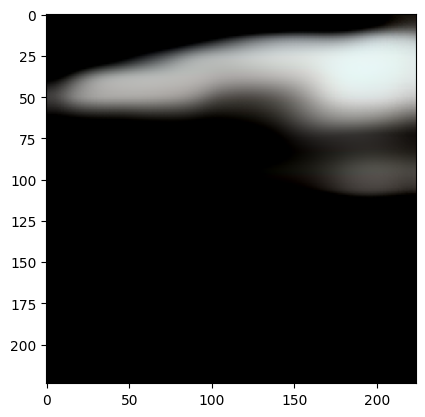

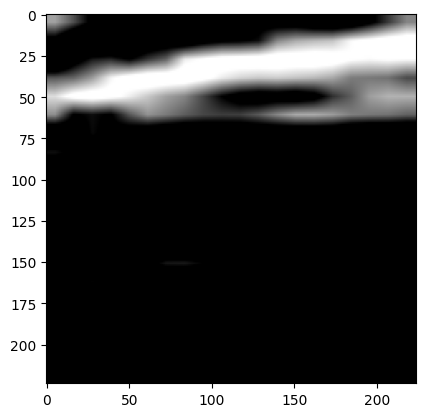

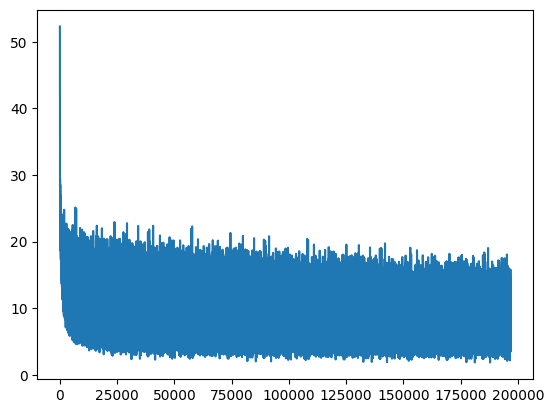

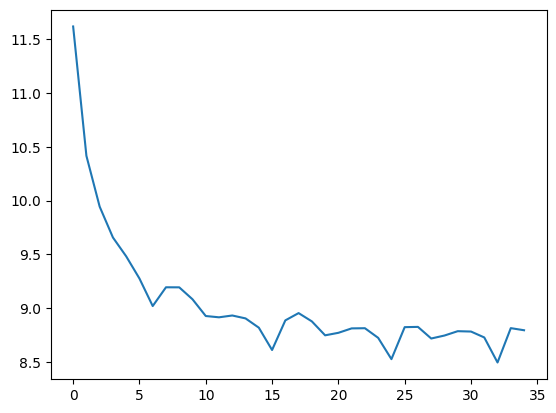

 12%|█████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 9/77 [22:52:33<173:18:41, 9175.31s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7fcb522b4c90>, test/blurry_pixcorr=0.809, test/loss=8.79, test/loss_clip_total=0.00239, test/loss_prior=0.293, test/num_steps=35, test/test_bwd_pct_correct=1, test/test_fwd_pct_correct=1, train/blurry_pixcorr=0.903, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.21, train/loss_

[E32/100 I0/5625]
  Loss 11.641195297241211
[E32/100 I50/5625]
  Loss 5.980123043060303
[E32/100 I100/5625]
  Loss 6.259274959564209
[E32/100 I150/5625]
  Loss 10.038651466369629
[E32/100 I200/5625]
  Loss 14.695930480957031
[E32/100 I250/5625]
  Loss 8.293232917785645
[E32/100 I300/5625]
  Loss 6.756048202514648
[E32/100 I350/5625]
  Loss 8.086930274963379
[E32/100 I400/5625]
  Loss 6.605596542358398
[E32/100 I450/5625]
  Loss 14.118422508239746
[E32/100 I500/5625]
  Loss 7.42274284362793
[E32/100 I550/5625]
  Loss 9.790611267089844
[E32/100 I600/5625]
  Loss 4.634705066680908
[E32/100 I650/5625]
  Loss 7.700798511505127
[E32/100 I700/5625]
  Loss 5.069606304168701
[E32/100 I750/5625]
  Loss 7.562859535217285
[E32/100 I800/5625]
  Loss 5.722951412200928
[E32/100 I850/5625]
  Loss 11.898740768432617
[E32/100 I900/5625]
  Loss 6.7234673500061035
[E32/100 I950/5625]
  Loss 8.764226913452148
[E32/100 I1000/5625]
  Loss 12.594691276550293
[E32/100 I1050/5625]
  Loss 10.820512771606445
[E32

In [ ]:
### tracking
# epoch = 0
# losses, test_losses, lrs = [], [], []
# best = {"loss": 1e9, "epoch": 0}
torch.cuda.empty_cache()

### optimization
mse = nn.MSELoss()
l1 = nn.L1Loss()
cfg["model"]["cos_anneal_start"] = 0.004
cfg["model"]["cos_anneal_end"] = 0.0075
soft_loss_temps = utils.cosine_anneal(
    cfg["model"]["cos_anneal_start"],
    cfg["model"]["cos_anneal_end"],
    cfg["model"]["num_epochs"] - int(cfg["model"]["mixup_pct"] * cfg["model"]["num_epochs"])
)

### run
model.to(cfg["device"])
progress_bar = tqdm(range(epoch, cfg["model"]["num_epochs"]), ncols=1200, disable=False)
seed_all(cfg["seed"])
for epoch in progress_bar:
    fwd_percent_correct = 0.
    bwd_percent_correct = 0.
    recon_cossim = 0.
    recon_mse = 0.
    loss_clip_total = 0.
    loss_blurry_total = 0.
    loss_blurry_cont_total = 0.
    loss_prior_total = 0.
    blurry_pixcorr = 0.

    train_dl = get_dataloaders(config=cfg)[0]["train"][cfg["data_name"]]

    ### train
    model.train()
    for train_i, batch in enumerate(train_dl):
        if train_i % 50 == 0:
            print(f"[E{epoch}/{cfg['model']['num_epochs']} I{train_i}/{cfg['model']['num_iterations_per_epoch']}]")
        with torch.cuda.amp.autocast(dtype=cfg["data_type"]):
            optimizer.zero_grad()
            loss = 0.

            ### select data
            voxel_list = [dp["resp"].unsqueeze(1).to(cfg["device"]) for dp in batch]  # (B, 1, num_voxels = num_of_neurons)
            image = img_tform(torch.cat([dp["stim"] for dp in batch], dim=0).to(cfg["device"]))  # (B, 3, 224, 224)

            ### augment image
            if cfg["model"]["use_image_aug"]: 
                image = img_augment(image)

            if epoch < int(cfg["model"]["mixup_pct"] * cfg["model"]["num_epochs"]):
                perm_list = [perm_iters[f"subj0{s}_iter{train_i}"].detach().to(cfg["device"]) for s in cfg["model"]["subj_list"]]
                perm = torch.cat(perm_list, dim=0)
                betas_list = [betas_iters[f"subj0{s}_iter{train_i}"].detach().to(cfg["device"]) for s in cfg["model"]["subj_list"]]
                betas = torch.cat(betas_list, dim=0).to(cfg["data_type"])
                select_list = [select_iters[f"subj0{s}_iter{train_i}"].detach().to(cfg["device"]) for s in cfg["model"]["subj_list"]]
                select = torch.cat(select_list, dim=0)

            ### map voxels to clip space
            voxel_ridge = torch.cat([model.ridge(voxel_list[si], si) for si, s in enumerate(cfg["model"]["subj_list"])], dim=0)
            backbone, clip_voxels, blurry_image_enc_ = model.backbone(voxel_ridge)

            ### map GT image to clip space
            clip_target = clip_img_embedder(image)
            assert not torch.any(torch.isnan(clip_target))

            ### normalize clip embeddings
            if cfg["model"]["clip_scale"] > 0:
                clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
                clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)

            if cfg["model"]["use_prior"]:
                loss_prior, prior_out = model.diffusion_prior(text_embed=backbone, image_embed=clip_target)
                if torch.isnan(loss_prior).any():
                    print(f"  Loss prior is NaN, skipping...")
                    del backbone, clip_voxels, blurry_image_enc_, clip_target, clip_voxels_norm, clip_target_norm, loss_prior, prior_out
                    import gc
                    gc.collect()
                    torch.cuda.empty_cache()
                    continue
                for i in range(3):
                    if torch.isnan(loss_prior).any():
                        print(f"  Loss prior is NaN, trying again...")
                        del loss_prior, prior_out
                        torch.cuda.empty_cache()
                        loss_prior, prior_out = model.diffusion_prior(text_embed=backbone, image_embed=clip_target)
                    else:
                        break

                loss_prior_total += loss_prior.item()
                loss_prior *= cfg["model"]["prior_scale"]
                loss += loss_prior

                recon_cossim += nn.functional.cosine_similarity(prior_out, clip_target).mean().item()
                recon_mse += mse(prior_out, clip_target).item()

            if cfg["model"]["clip_scale"] > 0:
                if epoch < int(cfg["model"]["mixup_pct"] * cfg["model"]["num_epochs"]):
                    loss_clip = utils.mixco_nce(
                        clip_voxels_norm,
                        clip_target_norm,
                        temp=.006,
                        perm=perm, betas=betas, select=select)
                else:
                    epoch_temp = soft_loss_temps[epoch - int(cfg["model"]["mixup_pct"] * cfg["model"]["num_epochs"])]
                    loss_clip = utils.soft_clip_loss(
                        clip_voxels_norm,
                        clip_target_norm,
                        temp=epoch_temp,
                    )

                loss_clip_total += loss_clip.item()
                loss_clip *= cfg["model"]["clip_scale"]
                loss += loss_clip

            if cfg["model"]["blurry_recon"]:     
                image_enc_pred, transformer_feats = blurry_image_enc_

                # image_enc = autoenc.encode(2 * image - 1).latent_dist.mode() * 0.18215
                image_enc = autoenc.encode(image).latent_dist.mode() * 0.18215  # already z-scored
                loss_blurry = l1(image_enc_pred, image_enc)
                loss_blurry_total += loss_blurry.item()

                if epoch < int(cfg["model"]["mixup_pct"] * cfg["model"]["num_epochs"]):
                    image_enc_shuf = image_enc[perm]
                    betas_shape = [-1] + [1]*(len(image_enc.shape)-1)
                    image_enc[select] = image_enc[select] * betas[select].reshape(*betas_shape) + \
                        image_enc_shuf[select] * (1 - betas[select]).reshape(*betas_shape)

                # image_norm = (image - mean) / std
                image_norm = image  # already z-scored
                # print(f"  Blurring Aug {image_norm.shape}")
                # image_aug = (blur_augs(image) - mean) / std
                image_aug = blur_augs(image)  # already z-scored
                _, cnx_embeds = cnx(image_norm)
                _, cnx_aug_embeds = cnx(image_aug)

                cont_loss = utils.soft_cont_loss(
                    nn.functional.normalize(transformer_feats.reshape(-1, transformer_feats.shape[-1]), dim=-1),
                    nn.functional.normalize(cnx_embeds.reshape(-1, cnx_embeds.shape[-1]), dim=-1),
                    nn.functional.normalize(cnx_aug_embeds.reshape(-1, cnx_embeds.shape[-1]), dim=-1),
                    temp=0.2)
                loss_blurry_cont_total += cont_loss.item()

                loss += (loss_blurry + 0.1 * cont_loss) * cfg["model"]["blur_scale"] #/.18215

            if cfg["model"]["clip_scale"]>0:
                # forward and backward top 1 accuracy        
                labels = torch.arange(len(clip_voxels_norm)).to(clip_voxels_norm.device) 
                fwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1).item()
                bwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1).item()

            if cfg["model"]["blurry_recon"]:
                with torch.no_grad():
                    # only doing pixcorr eval on a subset of the samples per batch because its costly & slow to compute autoenc.decode()
                    random_samps = np.random.choice(np.arange(len(image)), size=max(len(image)//5, 1), replace=False)
                    # blurry_recon_images = (autoenc.decode(image_enc_pred[random_samps]/0.18215).sample / 2 + 0.5).clamp(0,1)
                    blurry_recon_images = (autoenc.decode(image_enc_pred[random_samps]/0.18215).sample)
                    pixcorr = utils.pixcorr(image[random_samps], blurry_recon_images)
                    blurry_pixcorr += pixcorr.item()

            if train_i % 50 == 0:
                print(f"  Loss {loss.item()}")
            utils.check_loss(loss)
            # accelerator.backward(loss)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            lrs.append(optimizer.param_groups[0]['lr'])

            if cfg["model"]["optimization"]["lr_scheduler_type"] is not None:
                lr_scheduler.step()

            optimizer.zero_grad()
            torch.cuda.empty_cache()

    ### evaluate
    print("\n---Evaluating---\n")
    model.eval()
    with torch.no_grad(), torch.cuda.amp.autocast(dtype=cfg["data_type"]):
        n_minibatches = 0
        test_loss=0.
        test_loss_clip_total = 0.
        test_loss_prior_total = 0.
        test_blurry_pixcorr = 0.
        test_fwd_percent_correct = 0.
        test_bwd_percent_correct = 0.
        eval_dl = get_dataloaders(config=cfg)[0]["val"][cfg["data_name"]]
        for batch in eval_dl:
            voxel_list = [dp["resp"].unsqueeze(1).to(cfg["device"]) for dp in batch]  # (B, 1, num_voxels = num_of_neurons)
            image = img_tform(torch.cat([dp["stim"] for dp in batch], dim=0).to(cfg["device"]))  # (B, 3, 224, 224)

            voxel_ridge = torch.cat([model.ridge(voxel_list[si], si) for si, s in enumerate(cfg["model"]["subj_list"])], dim=0)
            backbone, clip_voxels, blurry_image_enc_ = model.backbone(voxel_ridge)

            clip_target = clip_img_embedder(image.float())
            if cfg["model"]["clip_scale"]>0:
                clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
                clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)

            if cfg["model"]["use_prior"]:
                loss_prior, _ = model.diffusion_prior(text_embed=backbone, image_embed=clip_target)
                test_loss_prior_total += loss_prior.item()
                loss_prior *= cfg["model"]["prior_scale"]
                test_loss += loss_prior

            if cfg["model"]["clip_scale"]>0:
                loss_clip = utils.soft_clip_loss(
                    clip_voxels_norm,
                    clip_target_norm,
                    temp=.006,
                )

                test_loss_clip_total += loss_clip.item()
                loss_clip = loss_clip * cfg["model"]["clip_scale"]
                test_loss += loss_clip

            if cfg["model"]["blurry_recon"]:
                image_enc_pred, _ = blurry_image_enc_
                # blurry_recon_images = (autoenc.decode(image_enc_pred/0.18215).sample / 2 + 0.5).clamp(0,1)
                blurry_recon_images = (autoenc.decode(image_enc_pred/0.18215).sample)
                pixcorr = utils.pixcorr(image, blurry_recon_images)
                test_blurry_pixcorr += pixcorr.item()

            if cfg["model"]["clip_scale"]>0:
                # forward and backward top 1 accuracy        
                labels = torch.arange(len(clip_voxels_norm)).to(clip_voxels_norm.device) 
                test_fwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1).item()
                test_bwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1).item()

            n_minibatches += 1

        test_loss /= n_minibatches
        test_loss_clip_total /= n_minibatches
        test_loss_prior_total /= n_minibatches
        test_blurry_pixcorr /= n_minibatches
        test_fwd_percent_correct /= n_minibatches
        test_bwd_percent_correct /= n_minibatches

        utils.check_loss(test_loss)                
        test_losses.append(test_loss.item())

        if test_loss.item() < best["loss"]:
            save_ckpt(f'best')
            best["loss"] = test_loss.item()
            best["epoch"] = epoch

        logs = {
            "train/loss": np.mean(losses[-(train_i+1):]),
            "test/loss": test_loss.item(),
            "train/lr": lrs[-1],
            "train/num_steps": len(losses),
            "test/num_steps": len(test_losses),
            "train/fwd_pct_correct": fwd_percent_correct / (train_i + 1),
            "train/bwd_pct_correct": bwd_percent_correct / (train_i + 1),
            "test/test_fwd_pct_correct": test_fwd_percent_correct,
            "test/test_bwd_pct_correct": test_bwd_percent_correct,
            "train/loss_clip_total": loss_clip_total / (train_i + 1),
            "train/loss_blurry_total": loss_blurry_total / (train_i + 1),
            "train/loss_blurry_cont_total": loss_blurry_cont_total / (train_i + 1),
            "test/loss_clip_total": test_loss_clip_total,
            "train/blurry_pixcorr": blurry_pixcorr / (train_i + 1),
            "test/blurry_pixcorr": test_blurry_pixcorr,
            "train/recon_cossim": recon_cossim / (train_i + 1),
            "train/recon_mse": recon_mse / (train_i + 1),
            "train/loss_prior": loss_prior_total / (train_i + 1),
            "test/loss_prior": test_loss_prior_total,
        }

        # if finished training, save jpg recons if they exist
        if (epoch == cfg["model"]["num_epochs"]-1) or (epoch % cfg["model"]["ckpt_interval"] == 0):
            if cfg["model"]["blurry_recon"]:    
                # image_enc = autoenc.encode(2*image[:4]-1).latent_dist.mode() * 0.18215
                image_enc = autoenc.encode(image[:4]).latent_dist.mode() * 0.18215  # already z-scored
                # transform blurry recon latents to images and plot it
                fig, axes = plt.subplots(1, 8, figsize=(10, 4))
                jj=-1
                for j in [0,1,2,3]:
                    jj+=1
                    # axes[jj].imshow(utils.torch_to_Image((autoenc.decode(image_enc[[j]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                    axes[jj].imshow(utils.torch_to_Image(autoenc.decode(image_enc[[j]]/0.18215).sample))
                    axes[jj].axis('off')
                    jj+=1
                    # axes[jj].imshow(utils.torch_to_Image((autoenc.decode(image_enc_pred[[j]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                    axes[jj].imshow(utils.torch_to_Image(autoenc.decode(image_enc_pred[[j]]/0.18215).sample))
                    axes[jj].axis('off')

                if wandb_log:
                    logs[f"test/blur_recons"] = wandb.Image(fig, caption=f"epoch{epoch:03d}")
                    plt.close()
                else:
                    plt.show()

        progress_bar.set_postfix(**logs)

        if wandb_log: wandb.log(logs)

    # Save model checkpoint and reconstruct
    # if (ckpt_saving) and (epoch % ckpt_interval == 0):
    if (epoch + 1) % 5 == 0:
        save_ckpt(f'ep{epoch}')
    save_ckpt(f'last')

    # wait for other GPUs to catch up if needed
    # accelerator.wait_for_everyone()
    torch.cuda.empty_cache()
    print(f"Finished epoch {epoch} / {cfg['model']['num_epochs']}")
    
    plt.imshow(blurry_recon_images[0].permute(1,2,0).cpu().detach().to(torch.float32))
    plt.show()
    plt.imshow(image[0].permute(1,2,0).cpu().detach().to(torch.float32))
    plt.show()
    plt.plot(losses)
    plt.show()
    plt.plot(test_losses)
    plt.show()

print("\n===Finished!===\n")
save_ckpt(f'last')

In [ ]:
plt.plot(losses)
plt.show()
plt.plot(test_losses)
plt.show()